In [145]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import integrate
from scipy import linalg
from scipy import interpolate
from math import cos

import PyQt5
from Classes import CrankNicolson, Hamiltonian, EMField
from Functions import Math, GroundState

from IPython.display import clear_output
%matplotlib notebook


<h3> Definición de los parámetros

In [219]:
Nx = 1000 #Número de puntos en el mallado espacial
Nt = 1000 #Número de puntos en el mallado temporal
x,h = np.linspace(-100,100,Nx,retstep=True) 
a = 1.0 #Paramentro que define el ancho de la función gaussiana
#p0 = 0.0 
x0 = 0.0  #Centro de la función gaussiana a tiempo 0
psi = np.exp(-(x-x0)**2/(2*a**2)) #Funcíón Gaussiana
C = integrate.simps(np.conjugate(psi)*psi,x) #Constante de normalización
psin = psi/np.sqrt(1) #Normalizamos la función de onda
t,dt = np.linspace(0,240,Nt,retstep=True) #Mallado temporal equiespaciado

<h3> Absorbing boundary condition

In [196]:
def AB(gamma,x):
    xb = 10
    #gamma = 2*xb*np.arccos(np.power(1.2,8))/np.pi
    l = ()
    #xb= 3/4*xmax
    
    mask = np.ones(len(x),dtype='float')
    for i in range(len(x)):
        if x[i]<(x[0]+xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
        if x[i]>(x[-1]-xb):
            mask[i] = np.power(np.cos(np.pi*x[i]*gamma/(2*xb)),1/8)
    return mask

<IPython.core.display.Javascript object>


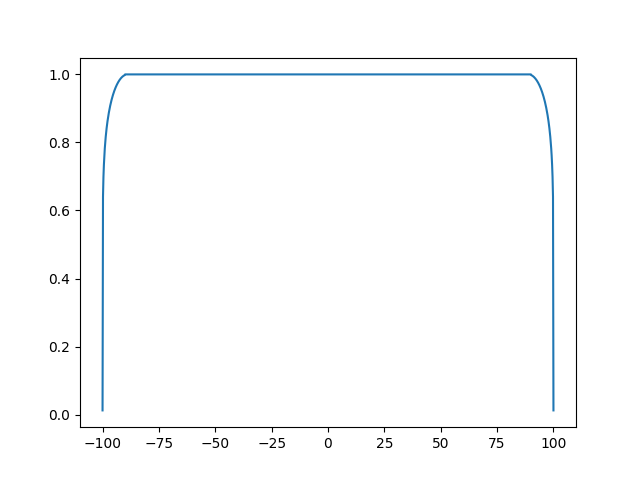

1000

In [209]:
fig = plt.figure();
ax = fig.add_subplot(111); #linear axis
x,h = np.linspace(-100,100,Nx,retstep=True) 

mask = AB(0.9,x)

ax.plot(x,mask)
len(ab)

<h3> Representación de la de la densidad de probabiliad de la
onda de partida 

<IPython.core.display.Javascript object>


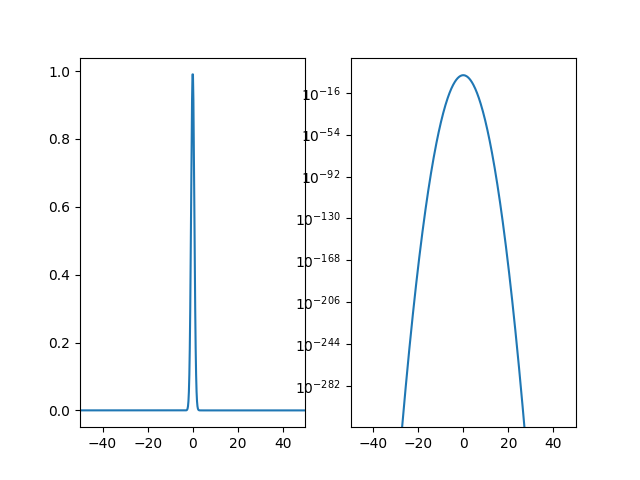

In [6]:
P = np.conjugate(psin)*psin #Densidad de probabilidad

fig = plt.figure();
axli = fig.add_subplot(121); #linear axis
axlo = fig.add_subplot(122); #logarithmic axis

axli.set_xlim(-50,50)
axlo.set_xlim(-50,50)

axli.plot(x,P);
axlo.plot(x,P);
axlo.set_yscale('log')
plt.show()

<h3> Evolución de la función de onda en ausencia de potencial y campo eléctrico

<IPython.core.display.Javascript object>


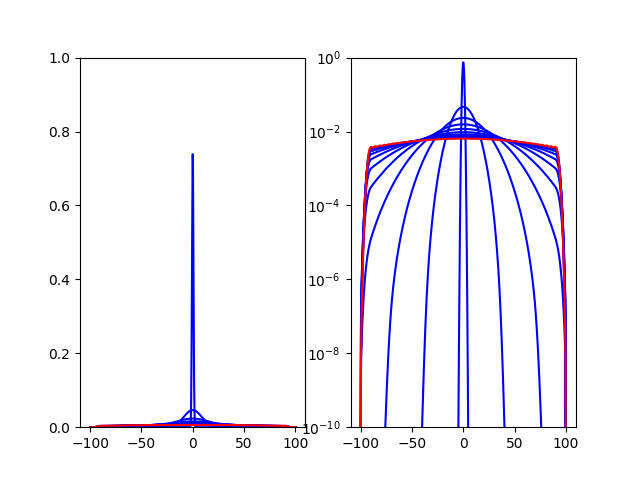

/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)
/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


CPU times: user 1min 22s, sys: 42 s, total: 2min 4s
Wall time: 41 s


In [210]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool=False,softening=1.0) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
psi0 = psin

for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    psi1 = Prop.Propagate(psi0) #Propaga de psi0 a psi1 un dt
    norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    psi1 = mask*psi1/np.sqrt(norm) #Normalizamos la función
    #CÓDIGO PARA GUARDAR CAPTURAS DE LAS GRÁFICAS
    #ax.title.set_text("Time: " + str(t[0][i]))
    #ax.plot(x,np.conjugate(psi1)*psi1,'b')
    #path = 'images/FPA/'+str(i)+'.png'
    #plt.savefig(path)
    #ax.clear()
    
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,np.conjugate(psi1)*psi1,'b');
        axlo.plot(x,np.conjugate(psi1)*psi1,'b');
    psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (lineal)
axlo.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<h3>Cálculo del estado fundamental del Hamiltoniano Coulombiano empleando propagación en tiempo imaginario

In [46]:
epc

(-0.5000077585306173+0j)

In [8]:
%%time 

def f(ep):
    return ep+0.5

delta = 1E-5

epdelta = 1E-5
sa = 1.90
sb = 2.10

eps = 1.

while (eps > epdelta): #Secant method
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sa)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epa = GroundState.GroundState(H,Prop,psin,x,delta)[1]

    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sb)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epb = GroundState.GroundState(H,Prop,psin,x,delta)[1]
                                    
    sc = sb-(f(epb))*(sb-sa)/(f(epb)-f(epa))
    
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epc = GroundState.GroundState(H,Prop,psin,x,delta)[1]
    
    eps = abs(abs(epc)-0.5)
    sa = sb
    sb = sc
                                    
print("epc: "+str(epc))
print("sc: " +str(sc))
print("eps: " + str(eps))

epc: (-0.4999999897553325+0j)
sc: (2.0369083358430493+0j)
eps: 1.0244667503211957e-08
CPU times: user 5min 58s, sys: 3min 9s, total: 9min 8s
Wall time: 2min 38s


In [57]:
%%time

#fig = plt.figure();
#axli = fig.add_subplot(121);
#axlo = fig.add_subplot(122);
#axli.set_ylim(0,1.0)
#axlo.set_ylim(1E-10,1.0)
#axli.set_xlim(-10,10)
#axlo.set_xlim(-10,10)



delta = 1E-5

epdelta = 1E-5
sa = 1.90
sb = 2.10

Prop = CrankNicolson.Propagator(H,Nx,dt)

H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sa)
epa = GroundState.GroundState(H,Prop,psin,x,delta)[1]

H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sb)
epb = GroundState.GroundState(H,Prop,psin,x,delta)[1]

eps = 1

while(eps>epdelta):
    clear_output()
    sc = (sa+sb)/2
    print(sc)
    H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc)
    Prop = CrankNicolson.Propagator(H,Nx,dt)
    epc = GroundState.GroundState(H,Prop,psin,x,delta)[1]
    
    eps = abs(abs(epc)-0.5)
    print(epc)
    print(eps)
    if (epc+0.5)*(epa+0.5)<0.0:
        sb = sc
    else: 
        sa = sc
        

#axli.plot(x,np.conjugate(psin)*psin,'b')
#axli.plot(x,np.conjugate(psiG)*psiG,'g')
#axlo.plot(x,np.conjugate(psin)*psin,'b')
#axlo.plot(x,np.conjugate(psiG)*psiG,'g')
#axlo.set_yscale('log')
print("epc: "+str(epc))
print("sc: " +str(sc))
print("eps: " + str(eps))

2.0369140624999993
(-0.4999993751444527+0j)
6.248555473042927e-07
epc: (-0.4999993751444527+0j)
sc: 2.0369140624999993
eps: 6.248555473042927e-07
CPU times: user 7min 51s, sys: 4min 7s, total: 11min 58s
Wall time: 3min 51s


<IPython.core.display.Javascript object>


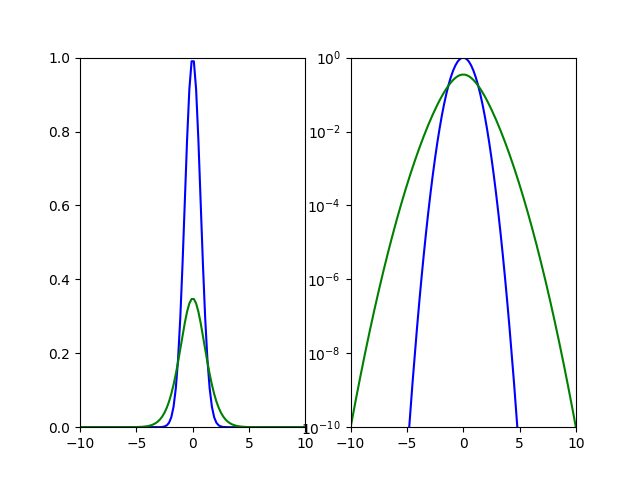

CPU times: user 37.7 s, sys: 18.9 s, total: 56.6 s
Wall time: 16.5 s


In [9]:
%%time

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)
axli.set_xlim(-10,10)
axlo.set_xlim(-10,10)
sc = np.real(sc)
dt = -1j*0.01 #En este caso definimos dt de manera arbitraria.
              #Afectará al número de iteraciones para alcanzar la
              #resolución deseada
        
#Volvemos a crear el Hamiltoniano, esta vez con el potencial
#Coulombiano activado. Al cambiar el Hamiltoniano tambien
#reiniciamos el propagador
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc) 
Prop = CrankNicolson.Propagator(H,Nx,dt)

#La función de onda de partida en este caso será la función normalizada
psi0 = psin
ep0 = Math.EigenEnergy(psi0,H,x)
eps = 1 #Iniciamos el error inicial para entrar en el loop
delta = 1E-5 #Error en la energía desesa
count = 0 #contado de iteraciones

while (eps>delta):
    psi1 = Prop.Propagate(psi0) #Propagamos la función de onda un j*dt
    norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    psi1 = psi1/np.sqrt(norm) #Normalizamos la función
    
    ep1 = Math.EigenEnergy(psi1,H,x) #Calculamos la autoenergía asociada
    eps = abs(ep1-ep0) #Calculamos el error absoluto
    
    #Movemos la función y su energía para la próxima iteración
    ep0 = ep1
    psi0 = psi1
    count +=1 
    
#Graficamos la función inicial y la final (estado fundamental)
axli.plot(x,np.conjugate(psin)*psin,'b')
axli.plot(x,np.conjugate(psi1)*psi1,'g')
axlo.plot(x,np.conjugate(psin)*psin,'b')
axlo.plot(x,np.conjugate(psi1)*psi1,'g')
axlo.set_yscale('log')

psiG = psi1 #Guardamos la función de onda del estado fundamental

In [10]:
print("Número de iteraciones: " + str(count))
print("Energía del estado fundamental" + str(ep1))

Número de iteraciones: 439
Energía del estado fundamental(-0.4999999897553325+0j)


<h3>Evolución temporal del estado fundamental

<IPython.core.display.Javascript object>


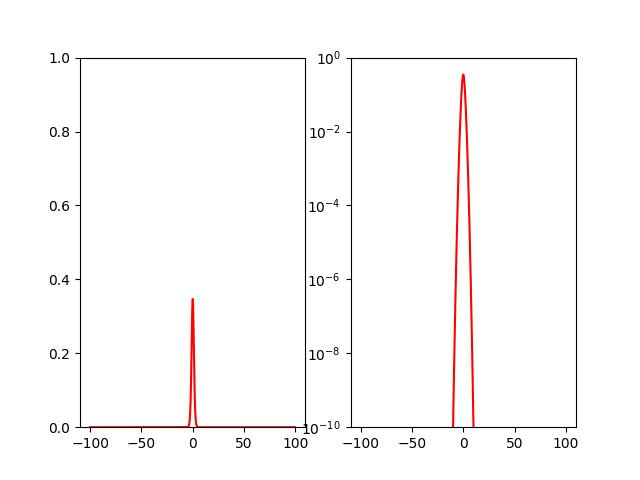

In [62]:
psi = psiG
fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


axli.plot(x,np.conjugate(psi)*psi,'r'); #Representamos el estado final (lineal)
axlo.plot(x,np.conjugate(psi)*psi,'r'); #Representamos el estado final (logarítmico)
axlo.set_yscale('log')

plt.show()

<IPython.core.display.Javascript object>


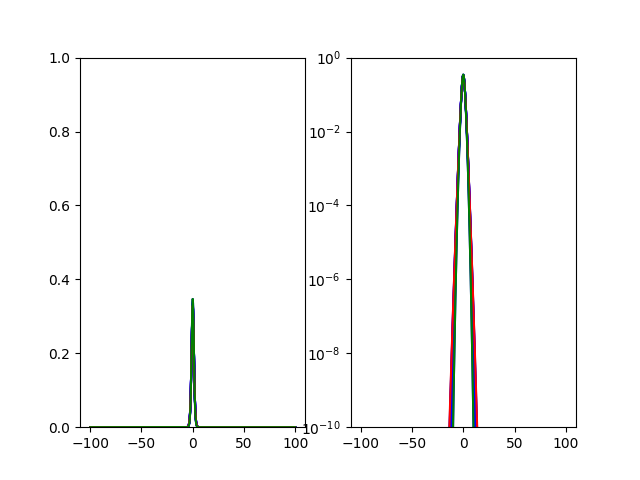

CPU times: user 1min 26s, sys: 47.9 s, total: 2min 14s
Wall time: 40.2 s


In [11]:
%%time 

fig = plt.figure();
axli = fig.add_subplot(121);
axlo = fig.add_subplot(122);
axli.set_ylim(0,1.0)
axlo.set_ylim(1E-10,1.0)


#Creamos el Hamiltoniano. En este caso desactivamos la opción del
#potencial Coulombiano y del potencial vector.
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool=False,softening=sc) 

#Creamos el propagador con los parámetros deseados
Prop = CrankNicolson.Propagator(H,Nx,dt)

#En este caso partimos de la función de onda sin normalizar 
#para que sea más visual
psi0 = psiG


for i in range(len(t)): #Se resolverá la propagación para cada instante de tiempo
    
    #Como se trata de un Hamiltoniano constante en el tiempo
    #no hará falta ejecutar Update() en cada iteración, tanto
    #en el Hamiltoniano como en el propagador
    
    psi1 = Prop.Propagate(psi0) #Propaga de psi0 a psi1 un dt
    norm = Math.Norm(psi1,x) #Calculamos la constate de normalización
    psi1 = psi1/np.sqrt(norm) #Normalizamos la función
    #CÓDIGO PARA GUARDAR CAPTURAS DE LAS GRÁFICAS
    #ax.title.set_text("Time: " + str(t[0][i]))
    #ax.plot(x,np.conjugate(psi1)*psi1,'b')
    #path = 'images/FPA/'+str(i)+'.png'
    #plt.savefig(path)
    #ax.clear()
    
    if (i%100 == 0): #Representaremos unicamente las iteraciones multiplos de 100
        axli.plot(x,np.conjugate(psi1)*psi1,'b');
        axlo.plot(x,np.conjugate(psi1)*psi1,'b');
    psi0 = psi1 #Movemos la función para la próxima iteración

axli.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (lineal)
axlo.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final (logarítmico)
axli.plot(x,np.conjugate(psiG)*psiG,'g'); #Representamos el estado inicial (lineal)
axlo.plot(x,np.conjugate(psiG)*psiG,'g'); #Representamos el estado inicial (logarítmico)
axlo.set_yscale('log')

plt.show()

In [71]:
s = sc
ep = Math.EigenEnergy(psi1,H,x)
print("ep: "+str(ep))
print("s: " +str(s))

ep: (-0.5011987212611003+0j)
s: 2.0369083358430493


Se observa como existe una diferencia de aproxiamadamente de 1E-3 en la energia al evolucionar el estado fundamental.

<h3>Propagación de la función de onda en presencia de un campo eléctrico

<IPython.core.display.Javascript object>


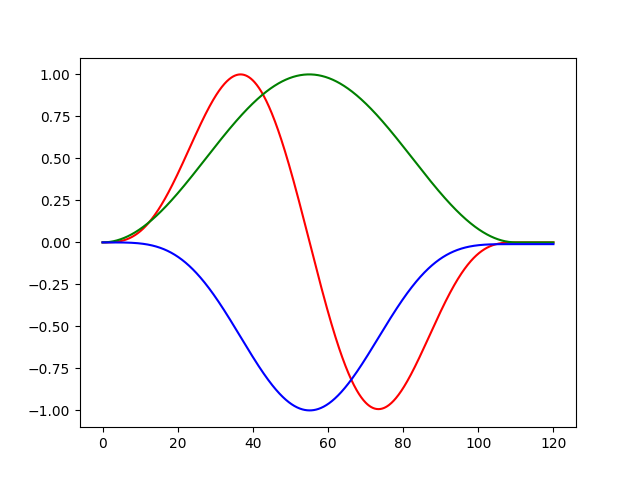

CPU times: user 849 ms, sys: 43.5 ms, total: 893 ms
Wall time: 835 ms


In [12]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
f = np.zeros(Nt)
e = np.zeros(Nt)
a = np.zeros(Nt)
EM = EMField.EMField(0.067,0.057,110)
#e=EM.E(t)
for i in range(len((t))):
    a[i] = EM.A(t[i])
    e[i] = EM.E(t[i])
    f[i] = EM.f(t[i])
    
ax.plot(t,e/np.amax(e),'r')
ax.plot(t,f,'g')
ax.plot(t,a/abs(np.amin(a)),'b')

In [25]:
dt

-0.01j

<IPython.core.display.Javascript object>


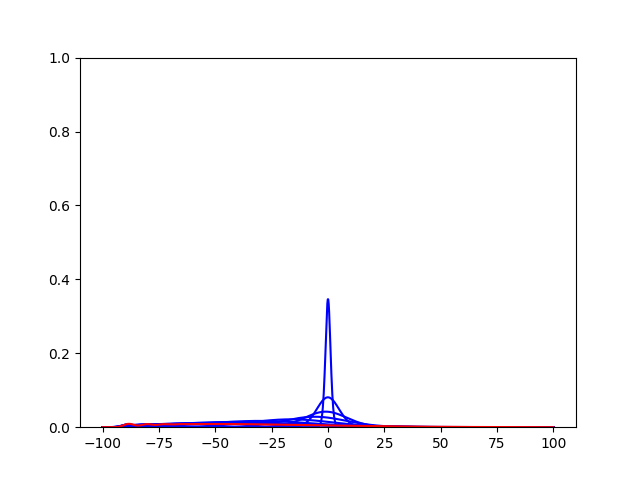

Calculando el potencial vector...
potencial vector calculado!
CPU times: user 1min 43s, sys: 51.9 s, total: 2min 35s
Wall time: 47.8 s


In [211]:
%%time
fig = plt.figure();
ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
ax.set_ylim(0,1.0)

#a = 10.0 #Paramentro que define el ancho de la función gaussiana
#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
#psi = np.exp(-np.power((x-x0),2)/(2*a**2)) #Funcíón Gaussiana
#psi = psin

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=False, ABool = True, softening=sc)
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    
    psi1 = mask*Prop.Propagate(psi0)  
    
    if (i%100== 0): #Rpresentamos solamente los multiplos de 100
        ax.plot(x,np.conjugate(psi1)*psi1,'b')
        
    psi0 = psi1 #Preparamos para la siguiente iteración

ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

In [22]:
#t = np.linspace(0,2.5*15,1000)
#fig = plt.figure();
#ax = fig.add_subplot(111);
#f = np.zeros(1000)
#e = np.zeros(1000)
#a = np.zeros(1000)
#EM = EMField.EMField(2000,1,5,10,-100,5)

#for i in range(len((t))):
#    a[i] = EM.A(t[i])
#    e[i] = EM.E(t[i])
#    f[i] = EM.f(t[i])
    
#ax.plot(t,e/np.amax(e))
#ax.plot(t,f)
#ax.plot(t,a/np.amax(a))

<h3>Propagación con el potencial Coulombiano y con campo 
    eléctrico

In [220]:
%%time

#fig = plt.figure();
#ax = fig.add_subplot(111);
#ax.set_xlim(-50,50)
#ax.set_ylim(0,1.0)

#Redefinimos el mallado temporal para este caso
#t,dt = np.linspace(0,120,Nt,retstep=True) 
#Redifinimos el mallado espacial para aumentarlo
#x,h = np.linspace(-100,100,Nx,retstep=True) 
#Recalculamos la función Gaussiana
psi = psiG

#Creamos un array donde se almacenará la densida de probabilidad
PMatrix = np.zeros((Nt,Nx))

#Volvemos a crear tanto el Hamiltoniano como el propagador.
#Los datos del campo EM estan definidos internamente en la clase
#del Hamiltoniano
H = Hamiltonian.H(x,Nx,h,t,VBool=True, ABool = True,softening=sc)
Prop = CrankNicolson.Propagator(H,Nx,dt)

psi0 = psiG #De nuevo partimos de la función de onda sin nomarlizar

for i in range(len(t)):
    H.Update(i) #Actualizamos el Hamiltoniano a la itreación i-ésima
    Prop.Update(H) #Actualizamos el porpagador con el nuevo Hamiltoniano
    PMatrix[i] = np.array(np.conjugate(psi0)*psi0)
    
    psi1 = mask*Prop.Propagate(psi0)  
    
    #if (i%100== 0): #Rpresentamos solamente los multiplos de 100
    #    ax.plot(x,np.conjugate(psi1)*psi1,'b')
    
    psi0 = psi1 #Preparamos para la siguiente iteración

#ax.plot(x,np.conjugate(psi1)*psi1,'r'); #Representamos el estado final

Calculando el potencial vector...
potencial vector calculado!


/home/rmhsik/Software/TFG/venv/lib/python3.7/site-packages/ipykernel_launcher.py:27: ComplexWarning: Casting complex values to real discards the imaginary part


CPU times: user 1min 43s, sys: 52.9 s, total: 2min 35s
Wall time: 45.1 s


<IPython.core.display.Javascript object>


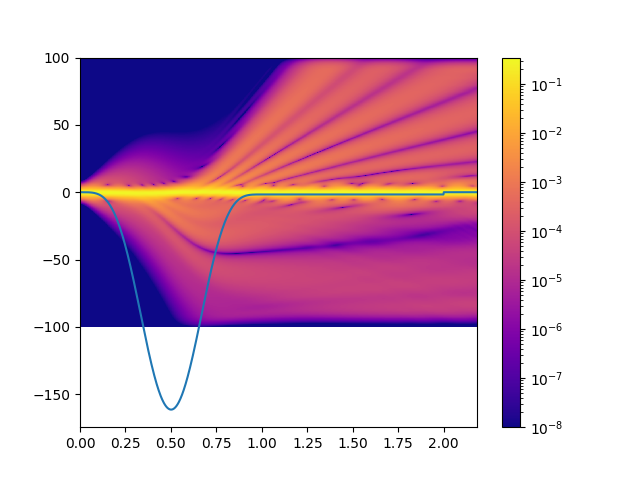

In [223]:
fig = plt.figure();
ax = fig.add_subplot(111);
c = ax.pcolormesh(t/110,x,np.transpose(PMatrix),cmap='plasma',norm=colors.LogNorm(vmin=1E-8,vmax=PMatrix.max()))
fig.colorbar(c, ax=ax)
ax.plot(t/110,H.A)
#ax.set_yscale('log')
#ax.set_ylim(-10,10)
plt.show()

In [37]:
PMatrix.max()

0.3468486008617382